In [1]:
import numpy as np
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from bokeh.io import show
from bokeh.plotting import figure

In [2]:
from pyro import Pyro

In [3]:
solver = "advection"
problem_name = "smooth"
param_file = "inputs.smooth"

In [4]:
pyro_sim = Pyro(solver)
pyro_sim.initialize_problem(problem_name, param_file)

pyro ...
initializing the smooth advection problem...


Solver = advection
Problem = smooth
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
advection.limiter = 2
advection.u = 1.0
advection.v = 1.0
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 1.0
driver.max_dt_change = 1e+33
driver.max_steps = 500
driver.tmax = 1.0
driver.verbose = 1.0
io.basename = smooth_
io.do_io = 1
io.dt_out = 0.2
io.n_out = 10000
mesh.nx = 32
mesh.ny = 32
mesh.xlboundary = periodic
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = periodic
mesh.ylboundary = periodic
mesh.ymax = 1.0
mesh.ymin = 0.0
mesh.yrboundary = periodic
particles.do_particles = 1
particles.n_particles = 100
particles.particle_generator = grid
vis.dovis = 1
vis.store_images = 0



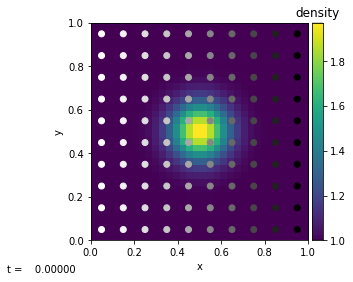

<Figure size 432x288 with 0 Axes>

In [5]:
print(pyro_sim)
pyro_sim.sim.dovis()

In [6]:
extra_parameters = {'vis.dovis': False, 'mesh.nx': 8, 'mesh.ny':8, 'particles.do_particles': False}
pyro_sim.initialize_problem(problem_name, param_file, inputs_dict=extra_parameters)
pyro_sim.run_sim()

initializing the smooth advection problem...
    1    0.10000    0.10000
    2    0.20000    0.10000
outputting...
    3    0.30000    0.10000
    4    0.40000    0.10000
outputting...
    5    0.50000    0.10000
    6    0.60000    0.10000
    7    0.70000    0.10000
outputting...
    8    0.80000    0.10000
    9    0.90000    0.10000
outputting...
   10    1.00000    0.10000
   11    1.00000    0.00000
outputting...
outputting...
parameter vis.store_images never used
main:  0.08861684799194336


In [7]:
dens = pyro_sim.get_var("density")
print(dens)

[[1.36456254 1.1670318  1.01964861 1.0019269  1.0034205  1.03779893
  1.19356852 1.36368295 1.36456254 1.1670318  1.01964861 1.0019269
  1.0034205  1.03779893 1.19356852 1.36368295]
 [1.1670318  1.1010689  1.01794261 1.00172162 1.00146403 1.00815036
  1.05467319 1.14089365 1.1670318  1.1010689  1.01794261 1.00172162
  1.00146403 1.00815036 1.05467319 1.14089365]
 [1.01964861 1.01794261 1.00386665 1.00034788 1.00015378 1.00017897
  1.00141073 1.01213761 1.01964861 1.01794261 1.00386665 1.00034788
  1.00015378 1.00017897 1.00141073 1.01213761]
 [1.0019269  1.00172162 1.00034788 1.00025512 1.00085108 0.99958517
  0.99836213 1.00032876 1.0019269  1.00172162 1.00034788 1.00025512
  1.00085108 0.99958517 0.99836213 1.00032876]
 [1.0034205  1.00146403 1.00015378 1.00085108 1.00036435 0.99369049
  0.99065988 1.00056788 1.0034205  1.00146403 1.00015378 1.00085108
  1.00036435 0.99369049 0.99065988 1.00056788]
 [1.03779893 1.00815036 1.00017897 0.99958517 0.99369049 0.97697494
  0.9889869  1.024

In [8]:
img = dens

p = figure()

# must give a vector of image data for image parameter
p.image(image=[img], x=0, y=0,dw = 10, dh = 10, palette="Spectral11")

show(p)  


    def method_compute_timestep(self):
        """
        Compute the advective timestep (CFL) constraint.  We use the
        driver.cfl parameter to control what fraction of the CFL
        step we actually take.
        """

        cfl = self.rp.get_param("driver.cfl")

        u = self.rp.get_param("advection.u")
        v = self.rp.get_param("advection.v")

        # the timestep is min(dx/|u|, dy/|v|)
        xtmp = self.cc_data.grid.dx/max(abs(u), self.SMALL)
        ytmp = self.cc_data.grid.dy/max(abs(v), self.SMALL)
        
        self.dt = cfl*min(xtmp, ytmp)
        
        
def evolve(self):
        """
        Evolve the linear advection equation through one timestep.  We only
        consider the "density" variable in the CellCenterData2d object that
        is part of the Simulation.
        """

        dtdx = self.dt/self.cc_data.grid.dx
        dtdy = self.dt/self.cc_data.grid.dy

        flux_x, flux_y = flx.unsplit_fluxes(self.cc_data, self.rp, self.dt, "density")

        """
        do the differencing for the fluxes now.  Here, we use slices so we
        avoid slow loops in python.  This is equivalent to:

        myPatch.data[i,j] = myPatch.data[i,j] + \
                               dtdx*(flux_x[i,j] - flux_x[i+1,j]) + \
                               dtdy*(flux_y[i,j] - flux_y[i,j+1])
        """

        dens = self.cc_data.get_var("density")

        dens.v()[:, :] = dens.v() + dtdx*(flux_x.v() - flux_x.ip(1)) + \
                                    dtdy*(flux_y.v() - flux_y.jp(1))

        if self.particles is not None:
            myg = self.cc_data.grid
            u = self.rp.get_param("advection.u")
            v = self.rp.get_param("advection.v")

            u2d = myg.scratch_array() + u
            v2d = myg.scratch_array() + v

            self.particles.update_particles(self.dt, u2d, v2d)

  # increment the time
        self.cc_data.t += self.dt
        self.n += 1
  
  
    def dovis(self):
        """
        Do runtime visualization.
        """
        dens = self.cc_data.get_var("density")

        myg = self.cc_data.grid

        _, axes, cbar_title = plot_tools.setup_axes(myg, 1)

        # plot density
        ax = axes[0]
img = ax.imshow(np.transpose(dens.v()),
 interpolation="nearest", origin="lower",
extent=[myg.xmin, myg.xmax, myg.ymin, myg.ymax],
cmap=self.cm)


        # needed for PDF rendering
        cb = axes.cbar_axes[0].colorbar(img)
        cb.formatter = matplotlib.ticker.FormatStrFormatter("")
        cb.solids.set_rasterized(True)
        cb.solids.set_edgecolor("face")

        plt.title("density")

        if self.particles is not None:
            particle_positions = self.particles.get_positions()

            # dye particles
            colors = self.particles.get_init_positions()[:, 0]

            # plot particles
            ax.scatter(particle_positions[:, 0],
                particle_positions[:, 1], c=colors, cmap="Greys")
            ax.set_xlim([myg.xmin, myg.xmax])
            ax.set_ylim([myg.ymin, myg.ymax])
        plt.pause(0.001)


from bokeh.io import show
from bokeh.plotting import figure
from bokeh.palettes import Viridis256

    def dovis(self):
        """
        Do runtime visualization.
        """


        dens = self.cc_data.get_var("density")

        myg = self.cc_data.grid

        _, axes, cbar_title = plot_tools.setup_axes(myg, 1)

        # plot density
        img = dens
        p = figure()

        # must give a vector of image data for image parameter
        pal = Viridis256
        p.image(image=[img], x=0, y=0,dw = 10, dh = 10, palette=pal)
        
        show(p)